## Data Preparation

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import scipy.io
import copy
from sklearn.calibration import calibration_curve
from scipy import interpolate
import logging
logger = logging.getLogger("fair")
from scipy.special import softmax
from sklearn.svm import SVC
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

In [2]:
path = r"..."
os.chdir(path)

In [3]:
X = pd.read_csv("MRI_processed_ctx_240227_final.csv") # AV45
Y = pd.read_csv("tau_processed_ctx_240227_final.csv") # AV1451
demogra = pd.read_csv("label_processed_ctx_240227_final.csv")

In [4]:
demogra.groupby('DXCURREN').groups[3.0].shape

(30,)

In [5]:
label = np.array(demogra['DXCURREN']).reshape(-1,1)

In [6]:
X = X.select_dtypes([np.number]) # 375 by 72
X.drop('RID', axis=1, inplace=True)
X

,RightParacentral,RightParahippocampal,RightParsOpercularis,RightParsOrbitalis,RightParsTriangularis,RightPericalcarine,RightPostcentral,RightPosteriorCingulate,RightPrecentral,RightPrecuneus,...,RightFrontalPole,RightFusiform,RightInferiorParietal,RightInferiorTemporal,RightIsthmusCingulate,RightLateralOccipital,RightLateralOrbitofrontal,RightLingual,RightMedialOrbitofrontal,RightMiddleTemporal
0,2.110,2.738,2.548,3.094,2.332,1.608,1.860,2.505,2.308,2.307,...,2.765,2.840,2.562,3.083,2.339,2.239,2.786,1.855,2.630,2.883
1,2.210,2.920,2.512,2.937,2.388,1.541,1.792,2.951,2.400,2.423,...,3.327,3.122,2.529,3.136,2.736,2.310,2.957,2.113,2.878,2.968
2,1.941,2.734,2.499,2.404,2.186,1.321,1.628,2.399,2.222,2.043,...,2.492,2.525,2.183,2.699,2.288,2.017,2.551,1.838,2.450,2.722
3,2.256,2.297,2.387,2.250,2.193,1.596,1.926,2.136,2.251,2.197,...,2.434,2.658,2.313,2.609,2.266,2.216,2.308,1.994,2.369,2.675
4,2.220,2.933,2.568,3.035,2.714,1.600,1.910,2.358,2.207,2.393,...,3.289,3.047,2.437,2.985,2.358,2.236,2.873,2.170,2.673,2.901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,2.191,2.972,2.277,2.375,2.053,1.653,1.702,2.414,2.393,2.246,...,2.399,2.916,2.221,3.084,2.389,2.081,2.598,2.121,2.333,2.792
371,2.540,2.591,2.764,3.015,2.698,1.923,2.095,2.453,2.620,2.468,...,3.112,3.080,2.635,3.156,2.729,2.391,2.916,2.134,2.652,3.092
372,2.571,2.260,2.476,2.792,2.563,1.638,1.975,2.655,2.398,2.541,...,2.493,2.956,2.703,2.987,2.482,2.211,2.898,2.092,2.497,3.089
373,2.185,2.682,2.147,2.382,2.247,1.522,1.773,2.308,2.128,2.136,...,2.535,2.697,2.141,2.631,2.054,2.043,2.394,1.926,2.368,2.694


In [7]:
Y = Y.select_dtypes([np.number]) # 375 by 72
Y.drop('RID', axis=1, inplace=True)
Y

,CTX_LH_BANKSSTS_SUVR,CTX_LH_CAUDALANTERIORCINGULATE_SUVR,CTX_LH_CAUDALMIDDLEFRONTAL_SUVR,CTX_LH_CUNEUS_SUVR,CTX_LH_ENTORHINAL_SUVR,CTX_LH_FRONTALPOLE_SUVR,CTX_LH_FUSIFORM_SUVR,CTX_LH_INFERIORPARIETAL_SUVR,CTX_LH_INFERIORTEMPORAL_SUVR,CTX_LH_INSULA_SUVR,...,CTX_RH_PRECENTRAL_SUVR,CTX_RH_PRECUNEUS_SUVR,CTX_RH_ROSTRALANTERIORCINGULATE_SUVR,CTX_RH_ROSTRALMIDDLEFRONTAL_SUVR,CTX_RH_SUPERIORFRONTAL_SUVR,CTX_RH_SUPERIORPARIETAL_SUVR,CTX_RH_SUPERIORTEMPORAL_SUVR,CTX_RH_SUPRAMARGINAL_SUVR,CTX_RH_TEMPORALPOLE_SUVR,CTX_RH_TRANSVERSETEMPORAL_SUVR
0,1.360,1.158,1.313,1.267,1.830,1.420,1.372,1.401,1.487,1.245,...,1.234,1.306,1.140,1.392,1.323,1.326,1.313,1.309,1.232,1.075
1,1.328,1.093,1.278,1.227,1.622,1.359,1.324,1.331,1.442,1.137,...,1.086,1.319,1.039,1.209,1.207,1.186,1.263,1.270,1.089,0.886
2,1.490,1.093,1.401,1.306,1.625,1.254,1.553,1.521,1.592,1.294,...,1.256,1.350,1.211,1.300,1.340,1.422,1.401,1.360,1.530,1.092
3,1.231,0.845,1.187,0.966,1.207,1.375,1.149,1.261,1.303,1.084,...,1.065,1.051,0.902,1.153,1.168,1.166,1.077,1.168,1.093,0.894
4,1.472,0.855,1.181,0.939,1.292,1.156,1.318,1.308,1.565,1.165,...,1.105,1.189,1.001,1.233,1.128,1.148,1.265,1.265,1.090,0.999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,0.963,0.935,1.043,1.022,1.049,1.154,1.100,1.044,1.213,1.003,...,0.924,1.003,0.878,1.076,1.005,1.024,1.082,1.059,0.951,0.898
371,1.251,1.120,1.270,1.096,1.163,1.525,1.275,1.254,1.368,1.282,...,1.155,1.214,1.063,1.408,1.262,1.134,1.221,1.311,1.268,0.871
372,0.961,0.854,0.944,0.732,1.026,1.210,1.096,1.014,1.127,0.940,...,0.878,0.912,0.944,0.981,1.022,0.889,0.991,0.966,0.978,0.725
373,1.031,1.016,1.166,1.001,1.255,1.329,1.140,1.377,1.276,1.110,...,1.057,1.103,1.003,1.125,1.052,1.106,1.090,1.133,1.051,0.903


In [8]:
X = np.array(X)
Y = np.array(Y)

In [9]:
z = np.array(demogra['PTGENDER']).reshape(-1,1)

## Algorithm for FRCCA

In [10]:
import numpy as np
from sklearn.cross_decomposition import CCA

class FairCCA:
    def __init__(self, R, scale=True, max_iter=int(1e4), tol=1e-10):
        self.R = R
        self.scale = scale
        self.max_iter = max_iter
        self.tol = tol
        self.R_x = None
        self.R_y = None
        self.cca = CCA(n_components=R, scale=scale, max_iter=max_iter, tol=tol)
        
    def fit(self, X, Y, z):
        X = (X - X.mean(axis=0)) / X.std(axis=0)
        Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)
        z = (z - z.mean()) / z.std()
        z = z.reshape(-1, 1)
        
        zX = z.T @ X
        _, _, Vt_x = np.linalg.svd(zX)
        self.R_x = Vt_x[:, 1:]
        
        zY = z.T @ Y
        _, _, Vt_y = np.linalg.svd(zY)
        self.R_y = Vt_y[:, 1:]
        
        X_new = X @ self.R_x
        Y_new = Y @ self.R_y
        
        self.cca.fit(X_new, Y_new)
        
    def transform(self, X, Y):
        X_new = (X - X.mean(axis=0)) / X.std(axis=0)
        Y_new = (Y - Y.mean(axis=0)) / Y.std(axis=0)
        X_transformed = X_new @ self.R_x
        Y_transformed = Y_new @ self.R_y
        X_c, Y_c = self.cca.transform(X_transformed, Y_transformed)
        X_c = X_c / (np.sqrt(np.sum(X_c**2, axis=0)))
        Y_c = Y_c / (np.sqrt(np.sum(Y_c**2, axis=0)))
        return X_c, Y_c
    
    def fit_transform(self, X, Y, z):
        self.fit(X, Y, z)
        return self.transform(X, Y)


## Baseline: Traditional CCA

In [11]:
corr_traditional_CCA_dim = []
fairness_traditional_CCA_dimX = []
fairness_traditional_CCA_dimY = []
for i in range(1, 5):
    cca = CCA(n_components=i)
    cca.fit(X,Y)
    X_c, Y_c = cca.transform(X, Y)
    X_c = X_c / (np.sqrt(np.sum(X_c**2, axis=0)))
    Y_c = Y_c / (np.sqrt(np.sum(Y_c**2, axis=0)))
    cov_trad_CCA = X_c.T@Y_c
    corr_trad_CCA = np.trace(cov_trad_CCA)
    corr_traditional_CCA_dim.append(corr_trad_CCA)
    fairness_traditional_CCAX = np.sum(np.abs(np.log(np.abs(z.T@X_c))))
    fairness_traditional_CCA_dimX.append(fairness_traditional_CCAX)
    fairness_traditional_CCAY = np.sum(np.abs(np.log(np.abs(z.T@Y_c))))
    fairness_traditional_CCA_dimY.append(fairness_traditional_CCAY)


corr_traditional_CCA_dim = np.array(corr_traditional_CCA_dim)
fairness_traditional_CCA_dimX = np.array(fairness_traditional_CCA_dimX)
fairness_traditional_CCA_dimY = np.array(fairness_traditional_CCA_dimY)

## Fairness and Correlation for FRCCA

### Data collection

In [12]:
corr_FRCCA_dim = []
fairness_FRCCA_dimX = []
fairness_FRCCA_dimY = []
for i in range(1, 5):
    fair_cca = FairCCA(R=i)
    X_proj, Y_proj = fair_cca.fit_transform(X, Y, z)
    cov_FRCCA = X_proj.T@Y_proj
    corr_FRCCA = np.trace(cov_FRCCA)
    corr_FRCCA_dim.append(corr_FRCCA)
    fairness_FRCCAX= np.sum(np.abs(np.log(np.abs(z.T@X_proj))))
    fairness_FRCCA_dimX.append(fairness_FRCCAX)
    fairness_FRCCAY= np.sum(np.abs(np.log(np.abs(z.T@Y_proj))))
    fairness_FRCCA_dimY.append(fairness_FRCCAY)

corr_FRCCA_dim = np.array(corr_FRCCA_dim)
fairness_FRCCA_dimX= np.array(fairness_FRCCA_dimX)
fairness_FRCCA_dimY = np.array(fairness_FRCCA_dimY)

### Plots

In [ ]:
from matplotlib.ticker import MaxNLocator
plt.rc('font', family='Times New Roman', weight='normal')
dimensions = np.array([1, 2, 3, 4])
corr_change = (corr_FRCCA_dim - corr_traditional_CCA_dim) / corr_traditional_CCA_dim 
fairnessX = (fairness_FRCCA_dimX - fairness_traditional_CCA_dimX) / fairness_traditional_CCA_dimX
fairnessY = (fairness_FRCCA_dimY - fairness_traditional_CCA_dimY) / fairness_traditional_CCA_dimY
fairness = (fairnessX + fairnessY) / 2
fig, ax = plt.subplots(figsize = (8,5))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='x', labelsize=18)  
ax.tick_params(axis='y', labelsize=18)  

fairness_bars = ax.bar(dimensions, fairness, width=0.4, color='#ff9549', label='Fairness')


correlation_bars = ax.bar(dimensions + 0.4, corr_change * 5000, width=0.4, color='lightblue', label='Correlation')


for bar in fairness_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize = 24)

for bar in correlation_bars:
    yval = bar.get_height()
    yval_2 = yval / 5000
    if yval <= 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval , f"{yval_2:.3f}", ha='center', va='top', fontsize = 24)
    else:
        plt.text(bar.get_x() + bar.get_width()/2, yval , f"{yval_2:.3f}", ha='center', va='bottom', fontsize = 24)
ax.set_ylim(-20, 120)        
ticks = np.array(ax.get_yticks())

ticks_to_change = ticks == -20

ticks[ticks_to_change] = -0.004

ax.set_yticklabels(ticks)
plt.grid(False)
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=1.5, color='grey')
ax.set_xlabel('Dimension', fontsize=22, fontweight='bold')
ax.set_ylabel('Percentage Change', fontsize=22, fontweight='bold')

plt.show()


## Fairness and Correlation for SFCCA

### Data Collection

In [14]:
corr_SFCCA_dim = []
fairness_SFCCA_dimX = []
fairness_SFCCA_dimY = []
for i in range(1, 5):
    address = r"..."
    mat = scipy.io.loadmat(address)
    U = mat[f'V{i}_av14_mri']
    V = mat[f'U{i}_av14_mri']
    X_proj = X@U
    Y_proj = Y@V
    X_proj = X_proj / (np.sqrt(np.sum(X_proj**2, axis=0)))
    Y_proj = Y_proj / (np.sqrt(np.sum(Y_proj**2, axis=0)))
    cov_SFCCA = X_proj.T@Y_proj
    corr_SFCCA = np.trace(cov_SFCCA)
    corr_SFCCA_dim.append(corr_SFCCA)
    fairness_SFCCAX= np.sum(np.abs(np.log(np.abs(z.T@X_proj))))
    fairness_SFCCA_dimX.append(fairness_SFCCAX)
    fairness_SFCCAY= np.sum(np.abs(np.log(np.abs(z.T@Y_proj))))
    fairness_SFCCA_dimY.append(fairness_SFCCAY)

corr_SFCCA_dim = np.abs(np.array(corr_SFCCA_dim))
fairness_SFCCA_dimX= np.array(fairness_SFCCA_dimX)
fairness_SFCCA_dimY = np.array(fairness_SFCCA_dimY)
corr_SFCCA_dim, fairness_SFCCA_dimX, fairness_SFCCA_dimY

(array([0.92060677, 1.50478184, 0.90023581, 1.67577972]),
 array([ 3.37922747,  6.67820781,  8.15246161, 11.81441224]),
 array([ 3.31485192,  6.40639544,  9.55192878, 12.83782653]))

### Plots

In [ ]:
from matplotlib.ticker import MaxNLocator
plt.rc('font', family='Times New Roman', weight='normal')
dimensions = np.array([1, 2, 3, 4])
corr_change = (corr_FRCCA_dim - corr_SFCCA_dim) / corr_SFCCA_dim 
fairnessX = (fairness_FRCCA_dimX - fairness_SFCCA_dimX) / fairness_SFCCA_dimX
fairnessY = (fairness_FRCCA_dimY - fairness_SFCCA_dimY) / fairness_SFCCA_dimY
fairness = (fairnessX + fairnessY) / 2
fig, ax = plt.subplots(figsize = (8,5))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='x', labelsize=18)  
ax.tick_params(axis='y', labelsize=18)  
 
fairness_bars = ax.bar(dimensions, fairness, width=0.4, color='orange', label='Fairness')


correlation_bars = ax.bar(dimensions + 0.4, corr_change, width=0.4, color='lightblue', label='Correlation')


for bar in fairness_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=24)

for bar in correlation_bars:
    yval = bar.get_height()
    yval_2 = yval
    if yval <= 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval , f"{yval_2:.3f}", ha='center', va='top', fontsize=24)
    else:
        plt.text(bar.get_x() + bar.get_width()/2, yval , f"{yval_2:.3f}", ha='center', va='bottom', fontsize=24)
ax.set_ylim(-1, 11)        
ticks = np.array(ax.get_yticks())

ticks_to_change = ticks == -20

ticks[ticks_to_change] = -0.04

ax.set_yticklabels(ticks)
plt.grid(False)
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=1.5, color='grey')
ax.set_xlabel('Dimension', fontsize=22, fontweight='bold')
ax.set_ylabel('Percentage Change',fontsize=22, fontweight='bold')
#ax.set_title('Fairness and Correlation by Dimension', fontsize = 18)


#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3, fontsize=14)
#ax.legend(fontsize = 18, fancybox=True)

plt.show()


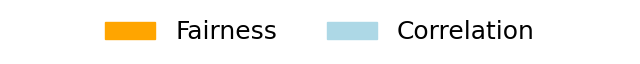

In [16]:
patch1 = patches.Patch(color='orange', label='Fairness')
patch2 = patches.Patch(color='lightblue', label='Correlation')

plt.figure(figsize=(8, 0.1))
plt.axis('off')

plt.legend(handles=[patch1, patch2], loc='center', ncol=2, frameon=False, fontsize=18)

plt.show()

## Fairness and Correlation for MFCCA

### Data Collection

In [17]:
corr_MFCCA_dim = []
fairness_MFCCA_dimX = []
fairness_MFCCA_dimY = []
for i in range(1, 5):
    address = r"..."
    mat = scipy.io.loadmat(address)
    U = mat[f'V{i}_av14_mri']
    V = mat[f'U{i}_av14_mri']
    X_proj = X@U
    Y_proj = Y@V
    X_proj = X_proj / (np.sqrt(np.sum(X_proj**2, axis=0)))
    Y_proj = Y_proj / (np.sqrt(np.sum(Y_proj**2, axis=0)))
    cov_MFCCA = X_proj.T@Y_proj
    corr_MFCCA = np.trace(cov_MFCCA)
    corr_MFCCA_dim.append(corr_MFCCA)
    fairness_MFCCAX= np.sum(np.abs(np.log(np.abs(z.T@X_proj))))
    fairness_MFCCA_dimX.append(fairness_MFCCAX)
    fairness_MFCCAY= np.sum(np.abs(np.log(np.abs(z.T@Y_proj))))
    fairness_MFCCA_dimY.append(fairness_MFCCAY)

corr_MFCCA_dim = np.abs(np.array(corr_MFCCA_dim))
fairness_MFCCA_dimX= np.array(fairness_MFCCA_dimX)
fairness_MFCCA_dimY = np.array(fairness_MFCCA_dimY)
corr_MFCCA_dim, fairness_MFCCA_dimX, fairness_MFCCA_dimY

(array([0.77274597, 1.34465543, 0.59100515, 1.47289229]),
 array([ 3.37773118,  6.64833848,  8.84068678, 12.00818803]),
 array([ 3.16853468,  6.24940235,  9.32096415, 12.5709518 ]))

### Plot

In [ ]:
from matplotlib.ticker import MaxNLocator

plt.rcParams.update({'font.size': 18})
dimensions = np.array([1, 2, 3, 4])
corr_change = (corr_FRCCA_dim - corr_MFCCA_dim) / corr_MFCCA_dim 
fairnessX = (fairness_FRCCA_dimX - fairness_MFCCA_dimX) / fairness_MFCCA_dimX
fairnessY = (fairness_FRCCA_dimY - fairness_MFCCA_dimY) / fairness_MFCCA_dimY
fairness = (fairnessX + fairnessY) / 2
fig, ax = plt.subplots(figsize = (8,5))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='x', labelsize=18)  
ax.tick_params(axis='y', labelsize=18)   
fairness_bars = ax.bar(dimensions, fairness, width=0.4, color='orange', label='Fairness')


correlation_bars = ax.bar(dimensions + 0.4, corr_change, width=0.4, color='lightblue', label='Correlation')


for bar in fairness_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom')

for bar in correlation_bars:
    yval = bar.get_height()
    yval_2 = yval
    if yval <= 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval , f"{yval_2:.3f}", ha='center', va='top')
    else:
        plt.text(bar.get_x() + bar.get_width()/2, yval , f"{yval_2:.3f}", ha='center', va='bottom')
ax.set_ylim(-1, 11)        
ticks = np.array(ax.get_yticks())

ticks_to_change = ticks == -20

ticks[ticks_to_change] = -0.04

ax.set_yticklabels(ticks)
plt.grid(False)
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=1.5, color='grey')
ax.set_xlabel('Dimension', fontsize=18, fontweight='bold')
ax.set_ylabel('Percentage Change',fontsize=18, fontweight='bold')

plt.show()


# Downstream Task (Classification)

## EO

In [19]:
def equalized_odds_class_wise(y, y_hat, sensitive_features, class_idx):
    y_hat = y_hat.ravel()
    y = y.ravel()
    group_true_pos_r = []
    values_of_sensible_feature = np.unique(sensitive_features)
    #print(values_of_sensible_feature)
    true_positive = np.sum([1.0 if y_hat[i] == class_idx and y[i] == class_idx
                             else 0.0 for i in range(len(y_hat))])
    #print(true_positive)
    all_positive = np.sum([1.0 if y[i] == class_idx else 0.0 for i in range(len(y_hat))])
    all_true_pos_r = true_positive / all_positive
    #print(all_true_pos_r)
    for val in values_of_sensible_feature:
        positive_sensitive = np.sum([1.0 if sensitive_features[i] == val and y[i] == class_idx else 0.0
                                     for i in range(len(y_hat))])
        if positive_sensitive > 0:
            true_positive_sensitive = np.sum([1.0 if y_hat[i] == class_idx and
                        sensitive_features[i] == val and y[i] == class_idx
                         else 0.0 for i in range(len(y_hat))])
            eo_tmp = true_positive_sensitive / positive_sensitive  # true positive rate
            group_true_pos_r.append(eo_tmp)

    return np.mean(np.abs(all_true_pos_r - group_true_pos_r))

## DP

In [20]:
def demographic_parity_multiclass_PR(y_hat, sensitive_features, class_idx):
        # measure the difference between the positive rates (TPR+FPR) of different groups
    y_hat = y_hat.ravel()
    values_of_sensible_feature = np.unique(sensitive_features)
    #print(values_of_sensible_feature)
    all_positive = np.sum([1.0 if y_hat[i] == class_idx else 0.0 for i in range(len(y_hat))])
    all_positive_rate = all_positive / len(y_hat)
    female_category = values_of_sensible_feature[0]
    male_category = values_of_sensible_feature[1]
    positive_female = np.sum([1.0 if sensitive_features[i] == female_category and y_hat[i] == class_idx 
                              else 0.0 for i in range(len(y_hat))])
    female_num = np.sum([1.0 if sensitive_features[i] == female_category else 0.0 for i in range(len(y_hat))])
    positive_rate_female = positive_female / female_num
        
        
    positive_male = np.sum([1.0 if sensitive_features[i] == male_category and y_hat[i] == class_idx 
                            else 0.0 for i in range(len(y_hat))])
    male_num = np.sum([1.0 if sensitive_features[i] == male_category else 0.0 for i in range(len(y_hat))])
    positive_rate_male = positive_male / male_num
    
    return np.abs(positive_rate_male - positive_rate_female)
    

## GS

In [21]:
def standard_suf_gap_all_class_wise(y, y_hat, A, class_idx=1):
    #y_hat = y_hat.ravel()
    num_A = len(np.unique(A))
    n_bins = 5
    interpolate_kind = 'linear'
    #print(y_hat.shape)
    #y_hat = softmax(y_hat, axis=1)  # normalize
   
    y_hat = y_hat[:,class_idx]  # choose the specific column (class)

    y_temp = copy.copy(y)
    y_temp[np.where(y != class_idx)[0]] = 0  # make all the other classes as 0
    y_temp[np.where(y == class_idx)[0]] = 1  # make the specific class as 1
    y = y_temp

    all_prob_true, all_prob_pred = calibration_curve(y, y_hat, n_bins=n_bins, pos_label=1)

    if all_prob_true.shape[0] != n_bins:
        logger.info('The range of prediction is not large enough for sufficiency gap computation, shrink the bins!')
    n_bins = all_prob_true.shape[0]
    groups_pred_true = np.zeros((num_A, n_bins))
    groups_pred_prob = np.zeros((num_A, n_bins))

    for i in range(len(np.unique(A))):
        try:
            t, p = calibration_curve(
                y[A == np.unique(A)[i]], y_hat[A == np.unique(A)[i]], n_bins=n_bins)
            if interpolate_kind:
                new_x = all_prob_pred
                f = interpolate.interp1d(
                    p,
                    t,
                    bounds_error=False,
                    fill_value=(t[0], t[-1]),
                    kind=interpolate_kind,
                )
                t = f(new_x)
                p = new_x
            groups_pred_true[i] = t
            groups_pred_prob[i] = p
        except:
            continue

    exp_x_given_a = np.abs(all_prob_true - groups_pred_true).mean(axis=1)
    exp_x_a = exp_x_given_a.mean()

    return exp_x_a

## Classifier Parameter Setup

In [29]:
param_grid1 = {
    'C': [20],
    'gamma': [0.5],
    'kernel': ['rbf']
}# Select Linear/Non-Linear Here

## Classification for FRCCA processed data

In [30]:
seeds = [42, 43, 44, 45, 46]
idx_train_all = []
idx_test_all = []
accuracy_FR = []
all_y_pred_FR = []
sensitive = []
all_y_test_FR = []
all_X_train = []
all_X_test = []
all_y_train = []
all_y_test = []
best_params = []
all_y_pred_prob_FR = []

In [31]:
for seed in seeds:
    label = label.ravel()
    indices = np.arange(X.shape[0])
    'Split the two modalities X, Y into Training set and Testing set'
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, label,
                                                                            indices, test_size=0.3,
                                                                            random_state=seed, stratify=label)
    Y_train, Y_test = Y[idx_train], Y[idx_test]
    z_train, z_test = z[idx_train], z[idx_test]
    
    
    all_X_train.append(X_train.tolist())
    all_X_test.append(X_test.tolist())
    all_y_train.append(y_train.tolist())
    all_y_test.append(y_test.tolist())
    
    'FRCCA on X_train/Y_train, and get the weights U/V'
    "X_train := Training Dataset of Modality X utilized in the classification by FRCCA,"
    "Y_train := Training Dataset of Modality Y utilized in the classification by FRCCA"
    fair_cca = FairCCA(R=2)
    fair_cca.fit(X_train, Y_train, z_train)
    Y_train, X_train = fair_cca.transform(X_train, Y_train)
    Y_test, X_test = fair_cca.transform(X_test, Y_test)
    'Store the index of the Training and Testing samples for further usage'
    idx_train_all.append(idx_train.tolist())
    idx_test_all.append(idx_test.tolist())
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    svc1 = SVC(random_state=seed, probability=True)
    clf1 = GridSearchCV(svc1, param_grid1, n_jobs=-1)
    clf1.fit(X_train, y_train)
    y_pred_FR = clf1.predict(X_test)
    all_y_pred_FR.append(y_pred_FR.tolist())
    all_y_test_FR.append(y_test.tolist())
    accuracy = accuracy_score(y_test, y_pred_FR)
    accuracy_FR.append(accuracy)
    sensitive.append(z[idx_test])
    best_param = clf1.best_params_
    best_params.append(best_param)
    y_pred_prob_FR = clf1.predict_proba(X_test)
    all_y_pred_prob_FR.append(y_pred_prob_FR.tolist())
accuracy_FR = np.array(accuracy_FR)
all_y_pred_prob_FR = np.array(all_y_pred_prob_FR)
all_y_pred_FR = np.array(all_y_pred_FR)
all_y_test_FR = np.array(all_y_test_FR)
all_X_train = np.array(all_X_train)
all_X_test = np.array(all_X_test)
all_y_train = np.array(all_y_train)
all_y_test = np.array(all_y_test)


## Classification for Traditional CCA processed data

In [32]:
accuracy_trad = []
all_y_pred_trad = []
all_y_test_trad = []
all_y_train_trad = []
all_X_train_trad = []
all_X_test_trad = []
all_y_pred_prob_trad = []

In [ ]:
for i in range(len(seeds)):
    X_train, Y_train = X[idx_train_all[i]], Y[idx_train_all[i]]
    X_test, Y_test = X[idx_test_all[i]], Y[idx_test_all[i]]
    cca1 = CCA(n_components=2)
    cca1.fit(X_train, Y_train)
    X_train, Y_train = cca1.transform(X_train, Y_train)
    X_train = X_train / (np.sqrt(np.sum(X_train**2, axis=0)))
    Y_train = Y_train / (np.sqrt(np.sum(Y_train**2, axis=0)))
    X_test, Y_test = cca1.transform(X_test, Y_test)
    X_test = X_test / (np.sqrt(np.sum(X_test**2, axis=0)))
    Y_test = Y_test / (np.sqrt(np.sum(Y_test**2, axis=0)))
    seed = seeds[i]
    X_train_trad, y_train_trad = Y_train, label[idx_train_all[i]].ravel()
    idx_train = idx_train_all[i]
    idx_test = idx_test_all[i]
    X_test_trad = Y_test
    y_test_trad = label[idx_test].ravel()

    scaler = StandardScaler()
    X_train_trad = scaler.fit_transform(X_train_trad)
    X_test_trad = scaler.transform(X_test_trad)
    svc2 = SVC(random_state=seed, probability=True)
    clf2 = GridSearchCV(svc2, param_grid1, n_jobs=None)
    clf2.fit(X_train_trad, y_train_trad)

    y_pred_trad = clf2.predict(X_test_trad)
    all_y_pred_trad.append(y_pred_trad.tolist())
    all_y_train_trad.append(y_train_trad.tolist())
    all_y_test_trad.append(y_test_trad.tolist())
    all_X_train_trad.append(X_train_trad.tolist())
    all_X_test_trad.append(X_test_trad.tolist())
    accuracy = accuracy_score(y_test_trad, y_pred_trad)
    accuracy_trad.append(accuracy)
    y_pred_prob_trad = clf2.predict_proba(X_test_trad)
    all_y_pred_prob_trad.append(y_pred_prob_trad.tolist())
accuracy_trad = np.array(accuracy_trad)
all_y_pred_trad = np.array(all_y_pred_trad)
all_y_train_trad = np.array(all_y_train_trad)
all_y_test_trad = np.array(all_y_test_trad)
all_X_train_trad = np.array(all_X_train_trad)
all_X_test_trad = np.array(all_X_test_trad)
all_y_pred_prob_trad = np.array(all_y_pred_prob_trad)

In [34]:
sensitive = np.array(sensitive)
sensitive.shape

(5, 113, 1)

## Classification for SFCCA

In [35]:
all_X_SFCCA = []
all_Y_SFCCA = []
for i in range(0,len(seeds)):
    address = fr"..."
    mat = scipy.io.loadmat(address)
    if i == 0:
        U = mat['V1_SF']    
        V = mat['U1_SF']
    else:
        U = mat['V_SF']
        V = mat['U_SF']
    X_SFCCA = X@U
    Y_SFCCA = Y@V
    all_X_SFCCA.append(X_SFCCA.tolist())
    all_Y_SFCCA.append(Y_SFCCA.tolist())
all_X_SFCCA = np.array(all_X_SFCCA)
all_Y_SFCCA = np.array(all_Y_SFCCA)

In [36]:
accuracy_SFCCA = []
all_y_pred_SFCCA = []
all_y_test_SFCCA = []
all_y_train_SFCCA = []
all_X_train_SFCCA = []
all_X_test_SFCCA = []
all_y_pred_prob_SFCCA = []

In [37]:
for i in range(len(seeds)):
    seed = seeds[i]
    idx_train = idx_train_all[i]
    idx_test = idx_test_all[i]
    X_train_SFCCA = all_Y_SFCCA[i][idx_train]
    X_test_SFCCA = all_Y_SFCCA[i][idx_test]
    y_train_SFCCA = label[idx_train].ravel()
    y_test_SFCCA = label[idx_test].ravel()
    X_train_SFCCA = X_train_SFCCA / (np.sqrt(np.sum(X_train_SFCCA**2, axis=0)))
    X_test_SFCCA = X_test_SFCCA / (np.sqrt(np.sum(X_test_SFCCA**2, axis=0)))
    scaler = StandardScaler()
    X__SFCCA = scaler.fit_transform(X__SFCCA)
    X_test_SFCCA = scaler.transform(X_test_SFCCA)
    svc5 = SVC(random_state=seed, probability=True)
    clf5 = GridSearchCV(svc5, param_grid1, n_jobs=-1)
    clf5.fit(X_train_SFCCA, y_train_SFCCA)

    y_pred_SFCCA = clf5.predict(X_test_SFCCA)
    all_y_pred_SFCCA.append(y_pred_SFCCA.tolist())
    all_y_train_SFCCA.append(y_train_SFCCA.tolist())
    all_y_test_SFCCA.append(y_test_SFCCA.tolist())
    all_X_train_SFCCA.append(X_train_SFCCA.tolist())
    all_X_test_SFCCA.append(X_test_SFCCA.tolist())
    accuracy = accuracy_score(y_test_SFCCA, y_pred_SFCCA)
    accuracy_SFCCA.append(accuracy)
    y_pred_prob_SFCCA = clf5.predict_proba(X_test_SFCCA)
    all_y_pred_prob_SFCCA.append(y_pred_prob_SFCCA.tolist())
accuracy_SFCCA = np.array(accuracy_SFCCA)
all_y_pred_SFCCA = np.array(all_y_pred_SFCCA)
all_y_train_SFCCA = np.array(all_y_train_SFCCA)
all_y_test_SFCCA = np.array(all_y_test_SFCCA)
all_X_train_SFCCA = np.array(all_X_train_SFCCA)
all_X_test_SFCCA = np.array(all_X_test_SFCCA)
all_y_pred_prob_SFCCA = np.array(all_y_pred_prob_SFCCA)

## Classification for MFCCA

In [38]:
all_X_MFCCA = []
all_Y_MFCCA = []
for i in range(0,len(seeds)):
    address = fr"..."
    mat = scipy.io.loadmat(address)
    if i == 0:
        U = mat['V1_MF']    
        V = mat['U1_MF']
    else:
        U = mat['V_MF']
        V = mat['U_MF']
    X_MFCCA = X@U
    Y_MFCCA = Y@V
    all_X_MFCCA.append(X_MFCCA.tolist())
    all_Y_MFCCA.append(Y_MFCCA.tolist())
all_X_MFCCA = np.array(all_X_MFCCA)
all_Y_MFCCA = np.array(all_Y_MFCCA)

In [39]:
accuracy_MFCCA = []
all_y_pred_MFCCA = []
all_y_test_MFCCA = []
all_y_train_MFCCA = []
all_X_train_MFCCA = []
all_X_test_MFCCA = []
all_y_pred_prob_MFCCA = []

In [40]:
for i in range(len(seeds)):
    seed = seeds[i]
    idx_train = idx_train_all[i]
    idx_test = idx_test_all[i]
    X_train_MFCCA = all_Y_MFCCA[i][idx_train]
    X_test_MFCCA = all_Y_MFCCA[i][idx_test]
    y_train_MFCCA = label[idx_train].ravel()
    y_test_MFCCA = label[idx_test].ravel()
    X_train_MFCCA = X_train_MFCCA / (np.sqrt(np.sum(X_train_MFCCA**2, axis=0)))
    X_test_MFCCA = X_test_MFCCA / (np.sqrt(np.sum(X_test_MFCCA**2, axis=0)))
    scaler = StandardScaler()
    X_train_MFCCA = scaler.fit_transform(X_train_MFCCA)
    X_test_MFCCA = scaler.transform(X_test_MFCCA)
    svc6 = SVC(random_state=seed, probability=True)
    clf6 = GridSearchCV(svc6, param_grid1, n_jobs=None)
    clf6.fit(X_train_MFCCA, y_train_MFCCA)

    y_pred_MFCCA = clf6.predict(X_test_MFCCA)
    all_y_pred_MFCCA.append(y_pred_MFCCA.tolist())
    all_y_train_MFCCA.append(y_train_MFCCA.tolist())
    all_y_test_MFCCA.append(y_test_MFCCA.tolist())
    all_X_train_MFCCA.append(X_train_MFCCA.tolist())
    all_X_test_MFCCA.append(X_test_MFCCA.tolist())
    accuracy = accuracy_score(y_test_MFCCA, y_pred_MFCCA)
    accuracy_MFCCA.append(accuracy)
    y_pred_prob_MFCCA = clf6.predict_proba(X_test_MFCCA)
    all_y_pred_prob_MFCCA.append(y_pred_prob_MFCCA.tolist())
accuracy_MFCCA = np.array(accuracy_MFCCA)
all_y_pred_MFCCA = np.array(all_y_pred_MFCCA)
all_y_train_MFCCA = np.array(all_y_train_MFCCA)
all_y_test_MFCCA = np.array(all_y_test_MFCCA)
all_X_train_MFCCA = np.array(all_X_train_MFCCA)
all_X_test_MFCCA = np.array(all_X_test_MFCCA)
all_y_pred_prob_MFCCA = np.array(all_y_pred_prob_MFCCA)

In [41]:
accuracy_svm = []
all_y_pred_svm = []
all_y_test_svm = []
all_y_train_svm = []
all_X_train_svm = []
all_X_test_svm = []
all_y_pred_prob_svm = []

In [42]:
for i in range(len(seeds)):
    X_train, Y_train = X[idx_train_all[i]], Y[idx_train_all[i]]
    X_test, Y_test = X[idx_test_all[i]], Y[idx_test_all[i]]
    X_train = X_train / (np.sqrt(np.sum(X_train**2, axis=0)))
    Y_train = Y_train / (np.sqrt(np.sum(Y_train**2, axis=0)))
    X_test = X_test / (np.sqrt(np.sum(X_test**2, axis=0)))
    Y_test = Y_test / (np.sqrt(np.sum(Y_test**2, axis=0)))
    seed = seeds[i]
    X_train_svm, y_train_svm = Y_train, label[idx_train_all[i]].ravel()
    idx_train = idx_train_all[i]
    idx_test = idx_test_all[i]
    X_test_svm = Y_test
    y_test_svm = label[idx_test].ravel()

    scaler = StandardScaler()
    X_train_MFCCA = scaler.fit_transform(X_train_MFCCA)
    X_test_MFCCA = scaler.transform(X_test_MFCCA)
    svc7 = SVC(random_state=seed, probability=True)
    clf7 = GridSearchCV(svc7, param_grid1, n_jobs=None)
    clf7.fit(X_train_svm, y_train_svm)

    y_pred_svm = clf7.predict(X_test_svm)
    all_y_pred_svm.append(y_pred_svm.tolist())
    all_y_train_svm.append(y_train_svm.tolist())
    all_y_test_svm.append(y_test_svm.tolist())
    all_X_train_svm.append(X_train_svm.tolist())
    all_X_test_svm.append(X_test_svm.tolist())
    accuracy = accuracy_score(y_test_svm, y_pred_svm)
    accuracy_svm.append(accuracy)
    y_pred_prob_svm = clf7.predict_proba(X_test_svm)
    all_y_pred_prob_svm.append(y_pred_prob_svm.tolist())
accuracy_svm = np.array(accuracy_svm)
all_y_pred_svm = np.array(all_y_pred_svm)
all_y_train_svm = np.array(all_y_train_svm)
all_y_test_svm = np.array(all_y_test_svm)
all_X_train_svm = np.array(all_X_train_svm)
all_X_test_svm = np.array(all_X_test_svm)
all_y_pred_prob_svm = np.array(all_y_pred_prob_svm)


# Measure DP and EO (Multi-class Classification)

In [44]:
def demographic_parity_multiclass_prediction_score(y_hat, sensitive_features):
    # get the maximum DP among all the classes
    y_hat = softmax(y_hat)  # normalize
    print(y_hat)
    all_p = np.std(y_hat, axis=0)  # the std prediction for each class
    p_sensible = []
    values_of_sensible_feature = np.unique(sensitive_features)
    for val in values_of_sensible_feature:
        p_sensible.append(y_hat[np.where(sensitive_features == val)[0]].std(axis=0))

    return np.std(np.abs(all_p - p_sensible).mean(axis=0))

In [45]:
def demographic_parity_multiclass_PR(y_hat, sensitive_features, class_idx):
        # measure the difference between the positive rates (TPR+FPR) of different groups
    y_hat = y_hat.ravel()
    values_of_sensible_feature = np.unique(sensitive_features)
    #print(values_of_sensible_feature)
    all_positive = np.sum([1.0 if y_hat[i] == class_idx else 0.0 for i in range(len(y_hat))])
    all_positive_rate = all_positive / len(y_hat)
    female_category = values_of_sensible_feature[0]
    male_category = values_of_sensible_feature[1]
    positive_female = np.sum([1.0 if sensitive_features[i] == female_category and y_hat[i] == class_idx 
                              else 0.0 for i in range(len(y_hat))])
    female_num = np.sum([1.0 if sensitive_features[i] == female_category else 0.0 for i in range(len(y_hat))])
    positive_rate_female = positive_female / female_num
        
        
    positive_male = np.sum([1.0 if sensitive_features[i] == male_category and y_hat[i] == class_idx 
                            else 0.0 for i in range(len(y_hat))])
    male_num = np.sum([1.0 if sensitive_features[i] == male_category else 0.0 for i in range(len(y_hat))])
    positive_rate_male = positive_male / male_num
    
    return np.abs(positive_rate_male - positive_rate_female)
    

## DP for FRCCA

In [46]:
all_DP_FR_pr = []
for j in range(len(seeds)):
    DP_FR_pr = []
    for i in range(1,4): # 3-Classes
        DP_FR_pr.append(demographic_parity_multiclass_PR(all_y_pred_FR[j], sensitive[j], class_idx=i))
    DP_FR_pr = np.mean(DP_FR_pr)
    all_DP_FR_pr.append(DP_FR_pr)
all_DP_FR_pr = np.array(all_DP_FR_pr)
all_DP_FR_pr

array([0.00318878, 0.01169591, 0.01608466, 0.01092896, 0.00020886])

## DP for Traditional CCA

In [47]:
all_DP_trad_pr = []
for j in range(len(seeds)):
    DP_trad_pr = []
    for i in range(1,4): # 3-Classes
        DP_trad_pr.append(demographic_parity_multiclass_PR(all_y_pred_trad[j], sensitive[j], class_idx=i))
    DP_trad_pr = np.mean(DP_trad_pr)
    all_DP_trad_pr.append(DP_trad_pr)
all_DP_trad_pr = np.array(all_DP_trad_pr)
all_DP_trad_pr

array([0.01679422, 0.02339181, 0.07492063, 0.01092896, 0.01169591])

## DP for SFCCA

In [48]:
all_DP_SFCCA_pr = []
for j in range(len(seeds)):
    DP_SFCCA_pr = []
    for i in range(1,4): # 3-Classes
        DP_SFCCA_pr.append(demographic_parity_multiclass_PR(all_y_pred_SFCCA[j], sensitive[j], class_idx=i))
    DP_SFCCA_pr = np.mean(DP_SFCCA_pr)
    all_DP_SFCCA_pr.append(DP_SFCCA_pr)
all_DP_SFCCA_pr = np.array(all_DP_SFCCA_pr)
all_DP_SFCCA_pr

array([0.02721088, 0.04887218, 0.01142857, 0.        , 0.0229741 ])

## DP for MFCCA

In [49]:
all_DP_MFCCA_pr = []
for j in range(len(seeds)):
    DP_MFCCA_pr = []
    for i in range(1,4): # 3-Classes
        DP_MFCCA_pr.append(demographic_parity_multiclass_PR(all_y_pred_MFCCA[j], sensitive[j], class_idx=i))
    DP_MFCCA_pr = np.mean(DP_MFCCA_pr)
    all_DP_MFCCA_pr.append(DP_MFCCA_pr)
all_DP_MFCCA_pr = np.array(all_DP_MFCCA_pr)
all_DP_MFCCA_pr

array([0.02636054, 0.01315789, 0.03259259, 0.        , 0.00020886])

## DP for SVM

In [50]:
all_DP_svm_pr = []
for j in range(len(seeds)):
    DP_svm_pr = []
    for i in range(1,4): # 3-Classes
        DP_svm_pr.append(demographic_parity_multiclass_PR(all_y_pred_svm[j], sensitive[j], class_idx=i))
    DP_svm_pr = np.mean(DP_svm_pr)
    all_DP_svm_pr.append(DP_svm_pr)
all_DP_svm_pr = np.array(all_DP_svm_pr)
all_DP_svm_pr

array([0.07355442, 0.0497076 , 0.06497354, 0.01702396, 0.02339181])

# EO Measurements

## EO for FR-CCA

In [51]:
all_EO_FR = []
for j in range(len(seeds)):
    EO_FR = []
    for i in range(1,4): # 3-Classes
        EO_FR.append(equalized_odds_class_wise(all_y_test_FR[j], all_y_pred_FR[j], sensitive_features=sensitive[j], class_idx=i))
    EO_FR = np.mean(EO_FR)
    all_EO_FR.append(EO_FR)
all_EO_FR = np.array(all_EO_FR)

## EO for Traditional CCA

In [52]:
all_EO_trad = []
for j in range(len(seeds)):
    EO_trad = []
    for i in range(1,4): # 3-Classes
        EO_trad.append(equalized_odds_class_wise(all_y_test_trad[j], all_y_pred_trad[j], sensitive_features=sensitive[j], class_idx=i))
    EO_trad = np.mean(EO_trad)
    all_EO_trad.append(EO_trad)
all_EO_trad = np.array(all_EO_trad)


## EO for SFCCA

In [53]:
all_EO_SFCCA = []
for j in range(len(seeds)):
    EO_SFCCA = []
    for i in range(1,4): # 3-Classes
        EO_SFCCA.append(equalized_odds_class_wise(all_y_test_SFCCA[j], all_y_pred_SFCCA[j], sensitive_features=sensitive[j], class_idx=i))
    EO_SFCCA = np.mean(EO_SFCCA)
    all_EO_SFCCA.append(EO_SFCCA)
all_EO_SFCCA = np.array(all_EO_SFCCA)

## EO for MFCCA

In [54]:
all_EO_MFCCA = []
for j in range(len(seeds)):
    EO_MFCCA = []
    for i in range(1,4): # 3-Classes
        EO_MFCCA.append(equalized_odds_class_wise(all_y_test_MFCCA[j], all_y_pred_MFCCA[j], sensitive_features=sensitive[j], class_idx=i))
    EO_MFCCA= np.mean(EO_MFCCA)
    all_EO_MFCCA.append(EO_MFCCA)
all_EO_MFCCA = np.array(all_EO_MFCCA)

## EO for SVM

In [55]:
all_EO_svm = []
for j in range(len(seeds)):
    EO_svm = []
    for i in range(1,4): # 3-Classes
        EO_svm.append(equalized_odds_class_wise(all_y_test_svm[j], all_y_pred_svm[j], sensitive_features=sensitive[j], class_idx=i))
    EO_svm= np.mean(EO_svm)
    all_EO_svm.append(EO_svm)
all_EO_svm = np.array(all_EO_svm)

# Group Sufficiency Measurement

In [56]:
import copy
from sklearn.calibration import calibration_curve
from scipy import interpolate
import logging
logger = logging.getLogger("fair")

## GS for FR

In [80]:
all_GS_FR = []
for j in range(len(seeds)):
    GS_FR = []
    for i in range(0,3): # 3-Classes
        GS_FR.append(standard_suf_gap_all_class_wise(all_y_test_FR[j], all_y_pred_prob_FR[j], A=sensitive[j], class_idx=i))
    GS_FR = np.mean(GS_FR)
    all_GS_FR.append(GS_FR)
all_GS_FR = np.array(all_GS_FR) 
all_GS_FR

array([0.1872428 , 0.28363146, 0.2391312 , 0.17538329, 0.1877572 ])

## GS for CCA

In [102]:

all_GS_trad = []
for j in range(len(seeds)):
    GS_trad = []
    for i in range(0,3): # 3-Classes
        GS_trad.append(standard_suf_gap_all_class_wise(all_y_test_trad[j], all_y_pred_prob_trad[j], A=sensitive[j], class_idx=i))
    GS_trad = np.mean(GS_trad)
    all_GS_trad.append(GS_trad)
all_GS_trad = np.array(all_GS_trad) 
all_GS_trad

array([0.29639978, 0.26802503, 0.31529882, 0.14315182, 0.17253669])

## GS for SFCCA

In [85]:
all_GS_SF = []
for j in range(len(seeds)):
    GS_SF = []
    for i in range(0,3): # 3-Classes
        GS_SF.append(standard_suf_gap_all_class_wise(all_y_test_SFCCA[j], all_y_pred_prob_SFCCA[j], A=sensitive[j], class_idx=i))
    GS_SF = np.mean(GS_SF)
    all_GS_SF.append(GS_SF)
all_GS_SF = np.array(all_GS_SF) 

## GS for MFCCA

In [86]:
all_GS_MF = []
for j in range(len(seeds)):
    GS_MF = []
    for i in range(0,3): # 3-Classes
        GS_MF.append(standard_suf_gap_all_class_wise(all_y_test_MFCCA[j], all_y_pred_prob_MFCCA[j], A=sensitive[j], class_idx=i))
    GS_MF = np.mean(GS_MF)
    all_GS_MF.append(GS_MF)
all_GS_MF = np.array(all_GS_MF) 

## GS for SVM

In [87]:
all_GS_svm = []
for j in range(len(seeds)):
    GS_svm = []
    for i in range(0,3): # 3-Classes
        GS_svm.append(standard_suf_gap_all_class_wise(all_y_test_svm[j], all_y_pred_prob_svm[j], A=sensitive[j], class_idx=i))
    GS_svm = np.mean(GS_svm)
    all_GS_svm.append(GS_svm)
all_GS_svm = np.array(all_GS_svm)

## Plot for Accuracy, EO, and DP between FRCCA & Traditional CCA

# Comparison Plot

In [88]:
DP_FRCCA_std = np.std(all_DP_FR_pr)
DP_trad_std = np.std(all_DP_trad_pr)
DP_SFCCA_std = np.std(all_DP_SFCCA_pr)
DP_MFCCA_std = np.std(all_DP_MFCCA_pr)
DP_svm_std = np.std(all_DP_svm_pr)

EO_FRCCA_std = np.std(all_EO_FR)
EO_trad_std = np.std(all_EO_trad)
EO_SFCCA_std = np.std(all_EO_SFCCA)
EO_MFCCA_std = np.std(all_EO_MFCCA)
EO_svm_std = np.std(all_EO_svm)

accuracy_FR_std = np.std(accuracy_FR)
accuracy_trad_std = np.std(accuracy_trad)
accuracy_SFCCA_std = np.std(accuracy_SFCCA)
accuracy_MFCCA_std = np.std(accuracy_MFCCA)
accuracy_svm_std = np.std(accuracy_svm)

GS_FR_std = np.std(all_GS_FR)
GS_trad_std = np.std(all_GS_trad)
GS_SFCCA_std = np.std(all_GS_SF)
GS_MFCCA_std = np.std(all_GS_MF)
GS_svm_std = np.std(all_GS_svm)

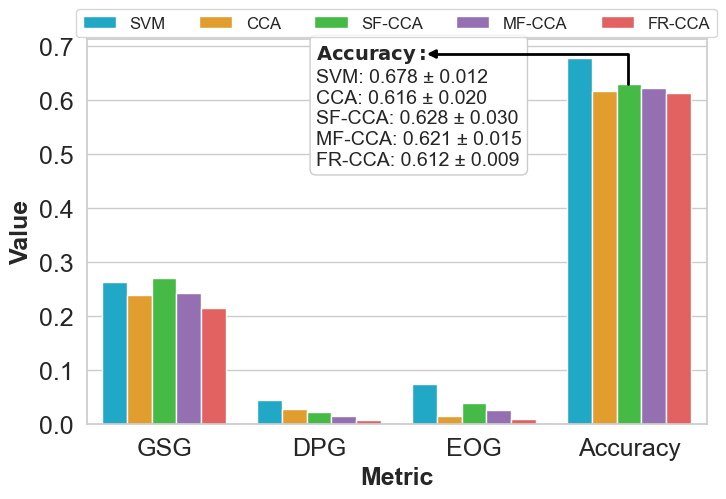

In [89]:
DP_FRCCA_mean = np.mean(all_DP_FR_pr)
DP_trad_mean = np.mean(all_DP_trad_pr)
DP_SFCCA_mean = np.mean(all_DP_SFCCA_pr)
DP_MFCCA_mean = np.mean(all_DP_MFCCA_pr)
DP_svm_mean = np.mean(all_DP_svm_pr)

EO_FRCCA_mean = np.mean(all_EO_FR)
EO_trad_mean = np.mean(all_EO_trad)
EO_SFCCA_mean = np.mean(all_EO_SFCCA)
EO_MFCCA_mean = np.mean(all_EO_MFCCA)
EO_svm_mean = np.mean(all_EO_svm)

accuracy_FR_mean = np.mean(accuracy_FR)
accuracy_trad_mean = np.mean(accuracy_trad)
accuracy_SFCCA_mean = np.mean(accuracy_SFCCA)
accuracy_MFCCA_mean = np.mean(accuracy_MFCCA)
accuracy_svm_mean = np.mean(accuracy_svm)

GS_FR_mean = np.mean(all_GS_FR)
GS_trad_mean = np.mean(all_GS_trad)
GS_SFCCA_mean = np.mean(all_GS_SF)
GS_MFCCA_mean = np.mean(all_GS_MF)
GS_svm_mean = np.mean(all_GS_svm)
data = {
    'Algorithm': ['SVM', 'SVM', 'SVM', 'SVM',
                  'CCA',  'CCA',  'CCA',  'CCA',
                  'SF-CCA','SF-CCA','SF-CCA','SF-CCA',
                  'MF-CCA','MF-CCA','MF-CCA','MF-CCA',
                  'FR-CCA', 'FR-CCA', 'FR-CCA','FR-CCA'
                 
                  
                  
                  ],
    'Metric': ['GSG', 'DPG', 'EOG', 'Accuracy',
               'GSG', 'DPG', 'EOG', 'Accuracy', 
               'GSG', 'DPG', 'EOG', 'Accuracy',
               'GSG', 'DPG', 'EOG', 'Accuracy',
               'GSG', 'DPG', 'EOG', 'Accuracy'
               ],
    'Value': [GS_svm_mean, DP_svm_mean, EO_svm_mean, accuracy_svm_mean,
              GS_trad_mean, DP_trad_mean, EO_trad_mean, accuracy_trad_mean,   
              GS_SFCCA_mean, DP_SFCCA_mean, EO_SFCCA_mean, accuracy_SFCCA_mean,
              GS_MFCCA_mean, DP_MFCCA_mean, EO_MFCCA_mean, accuracy_MFCCA_mean,
              GS_FR_mean, DP_FRCCA_mean, EO_FRCCA_mean, accuracy_FR_mean
              ]
              }
df = pd.DataFrame(data)

sns.set(style="whitegrid")

plt.figure(figsize=(8,5))
barplot = sns.barplot(x='Metric', y='Value', hue='Algorithm', data=df,
                      palette=["#05b9e2", "#ffa510", "limegreen", "#9564bc", "#f74d4d"], alpha=1)

accuracy_values_with_std = {
    'SVM': f"{accuracy_svm_mean:.3f} ± {accuracy_svm_std:.3f}",
    'CCA': f"{accuracy_trad_mean:.3f} ± {accuracy_trad_std:.3f}",
    'SF-CCA': f"{accuracy_SFCCA_mean:.3f} ± {accuracy_SFCCA_std:.3f}",
    'MF-CCA': f"{accuracy_MFCCA_mean:.3f} ± {accuracy_MFCCA_std:.3f}",
    'FR-CCA': f"{accuracy_FR_mean:.3f} ± {accuracy_FR_std:.3f}"
}

accuracy_text = "\n".join([f"{key}: {value}" for key, value in accuracy_values_with_std.items()])
accuracy_text = r"$\bf{Accuracy:}$" + "\n" + accuracy_text
plt.text(0.37, 0.99, accuracy_text, fontsize=14, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="#cccccc", facecolor="white"))
plt.annotate('', xy=(0.53, 0.89), xytext=(0.785, 0.825),
             xycoords='figure fraction', textcoords='figure fraction',
            arrowprops=dict(arrowstyle='-|>', color='black',
                             connectionstyle='angle,angleA=90,angleB=0,rad=0',
                             lw=2))
plt.xlabel('Metric', fontsize=18, fontweight='bold')
plt.ylabel('Value', fontsize=18, fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
legend = plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5)

plt.show()

In [94]:
data1 = {
  'acc_svm': accuracy_svm,
  'gs_svm': all_GS_svm,
  'dp_svm': all_DP_svm_pr,
  'eo_svm': all_EO_svm,
  
  'acc_trad': accuracy_trad,
  'gs_trad': all_GS_trad,
  'dp_trad': all_DP_trad_pr,
  'eo_trad': all_EO_trad,
  
  'acc_SFCCA': accuracy_SFCCA,
  'gs_SFCCA': all_GS_SF,
  'dp_SFCCA': all_DP_SFCCA_pr,
  'eo_SFCCA': all_EO_SFCCA,
  
  'acc_MFCCA': accuracy_MFCCA,
  'gs_MFCCA': all_GS_MF,
  'dp_MFCCA': all_DP_MFCCA_pr,
  'eo_MFCCA': all_EO_MFCCA,
  
  'acc_FRCCA': accuracy_FR,
  'gs_FRCCA': all_GS_FR,
  'dp_FRCCA': all_DP_FR_pr,
  'eo_FRCCA': all_EO_FR,
}
df = pd.DataFrame(data1, index=['SVM', 'CCA', 'SFCCA', 'MFCCA', 'FRCCA'])
df.to_csv('AV14.csv')